<a href="https://www.kaggle.com/code/aisuko/zero-shot-image-classification?scriptVersionId=164811961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Zero-shot image classification is a task that involves classifying images into different categories using a model that was not explicity trained on data containing labeled examples from those specific categories.

Traditionally, image classifiction requires training a model on a specific set of labeled images, and this model learns to "map" certain image features to labels. When there's a need to use such model for a classification task that introduces a new set of labels, fine-tuning is required to "recalibrate" the model. In contrast, **zero-shot or open vocabulary image classification models are typically multi-modal models that have been trained on a large dataset of images and associated descriptions**. These models learn aligned vision-language representations that can be used for many downstream tasks including zero-shot image classification. This is a more flexible approach to image classification that allows models to generalize to new and unseen categories without the need for additional training data and enables users to query images with free-form text descriptions of their target objects.

In [1]:
%%capture
!pip install transformers==4.35.2

# Loading the Pipeline

In [2]:
from transformers import pipeline

model_checkpoint="openai/clip-vit-large-patch14"
detector=pipeline(model=model_checkpoint, task="zero-shot-image-classification", device='cuda')
print(detector.device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda


# Loading the Image

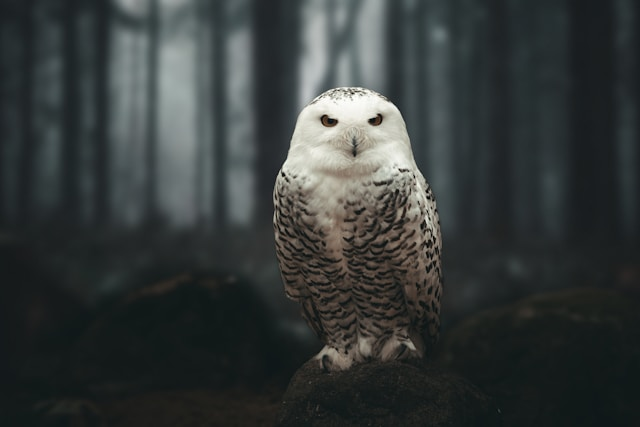

In [3]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/g8oS8-82DxI/download?ixid=MnwxMjA3fDB8MXx0b3BpY3x8SnBnNktpZGwtSGt8fHx8fDJ8fDE2NzgxMDYwODc&force=true&w=640"
image=Image.open(requests.get(url, stream=True).raw)
image

In [4]:
predictions=detector(image, candidate_labels=["fox","bear","seagull","owl"])
predictions

[{'score': 0.9992266893386841, 'label': 'owl'},
 {'score': 0.0006071239477023482, 'label': 'seagull'},
 {'score': 8.65067049744539e-05, 'label': 'fox'},
 {'score': 7.967835699673742e-05, 'label': 'bear'}]

# Zero-shot Image Classification

Let's see how to use the zero-shot image classification pipeline.

In [5]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

model=AutoModelForZeroShotImageClassification.from_pretrained(model_checkpoint)
processor=AutoProcessor.from_pretrained(model_checkpoint)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


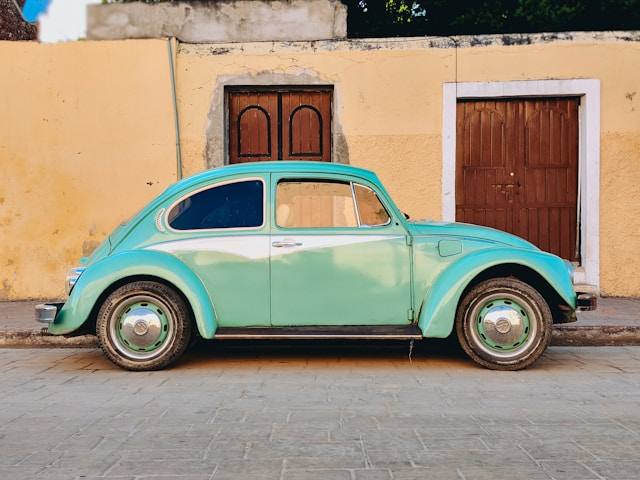

In [6]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/xBRQfR2bqNI/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjc4Mzg4ODEx&force=true&w=640"
image=Image.open(requests.get(url, stream=True).raw)
image

Here, we use the processor to prepare the inputs for the model. The processor combines an image that prepares the image for the model by resizing and normalizing it, and a tokenizer that takes care of the text inputs.

In [7]:
candidate_labels=["tree","car","bike","cat"]
inputs=processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)
print(inputs)

{'input_ids': tensor([[49406,  2677, 49407],
        [49406,  1615, 49407],
        [49406,  3701, 49407],
        [49406,  2368, 49407]]), 'attention_mask': tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]), 'pixel_values': tensor([[[[ 1.6092,  1.5800,  1.5654,  ..., -1.6463, -1.6901, -1.6755],
          [ 1.5946,  1.6092,  1.5654,  ..., -1.6755, -1.6609, -1.6901],
          [ 1.6092,  1.5946,  1.4924,  ..., -1.6171, -1.5003, -1.6609],
          ...,
          [ 0.4997,  0.4559,  0.4267,  ...,  0.3683,  0.3391,  0.3537],
          [ 0.1931, -0.0696,  0.1201,  ...,  0.3683,  0.3683,  0.3683],
          [ 0.5435,  0.4851,  0.5143,  ...,  0.4851,  0.2807,  0.2807]],

         [[ 1.7597,  1.7597,  1.7747,  ..., -1.4519, -1.4970, -1.4820],
          [ 1.7447,  1.7597,  1.7297,  ..., -1.4669, -1.4369, -1.4970],
          [ 1.7597,  1.7447,  1.6247,  ..., -1.3769, -1.2268, -1.4369],
          ...,
          [ 0.5591,  0.4991,  0.4691,  ...,  0.4090,  0.3940,  0.394

Pass the inputs through the model, and post-process the results:

In [8]:
import torch

with torch.no_grad():
    outputs=model(**inputs)
    
logits=outputs.logits_per_image[0]
probs=logits.softmax(dim=-1).numpy()
scores=probs.tolist()

result=[
    {"score": score, "label": candidate_label}
    for score, candidate_label in sorted(zip(probs,candidate_labels), key=lambda x:-x[0])
]

print(result)

[{'score': 0.99904805, 'label': 'car'}, {'score': 0.0006857826, 'label': 'bike'}, {'score': 0.00024006952, 'label': 'tree'}, {'score': 2.609836e-05, 'label': 'cat'}]
